# 图像拼接改进：
#### 1.使用Superpoint技术替换SIFT
#### 2.使用Superglue技术进行特征点匹配
#### 3.使用GMM进行非刚性变形


In [1]:
import cv2
from icecream import ic
from GMMRegistration.GMMreg import GMM
from Register import SuperglueReg
import os
import util
import numpy as np
from matplotlib import pyplot as plt
img_paths = ['./imgs/1.jpg', './imgs/2.jpg']
imgs = []
for p in img_paths:
    imgs.append(cv2.imread(p))


#### 加载配置

In [13]:
def getSuperglueInstance():
    superpoint_model_path = './weights/superpoint_v1.pth'
    superglue_model_path = './weights/superglue_indoor.pth'
    device = 'cuda:0'

    superglue = SuperglueReg(
    ve_model_path=None,
    ve_model_type=None,
    superpoint_model_path=superpoint_model_path,
    superglue_model_path=superglue_model_path,
    logger=None,
    device=device,
    ve_gan_batch_size=1,  # 图像预处理的线程数，区别不大
    nms_radius=4,  # 非极大值抑制参数， 可不改
    keypoint_threshold=0.02,  # 特征点提取阈值，可不改
    max_keypoints=250,  # 最大特征点数，可不改
    sinkhorn_iterations=20,  # 迭代次数，不改
    match_threshold=0.04,  # 配对阈值，不改
    do_debug=False
    # 以上参数除了tar_size默认-1，别的都设置了如上的默认参数，调用时不改可不写
    )
    return superglue

def merge(img1, img2):
    co_img2 = np.zeros_like(img1)
    co_img2[0:img2.shape[0], 0:img2.shape[1]] = img2
    mask = co_img2 > img1
    # 此处直接取两图重合部分中较亮的位置
    final = (co_img2 * mask + img1 * (1 - mask)).astype(np.uint8)
    return final

In [14]:
# 使用默认参数
superglue = getSuperglueInstance()

Loaded SuperPoint model
Loaded SuperGlue model ("superglue_indoor.pth" weights)


ic| 'SuperglueReg init'


In [15]:
fit_size = 512
for i, img in enumerate(imgs):
    img = img.astype('uint8')
    img = util.img_resize(img, fit_size)
    imgs[i] = img.astype('uint8')
    

#### 仿射变换

In [16]:
def stitch(img1, img2, pts1, pts2):
    
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    result = cv2.warpPerspective(img1, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    # 防止边界溢出, 加一些边框
    disVertical = abs(img2.shape[0] - result.shape[0])
    disHorizontal = abs(img2.shape[1] - result.shape[1])
    result = cv2.copyMakeBorder(result, disVertical, disVertical, 0, disHorizontal, cv2.BORDER_CONSTANT, None, [0,0,0])

    # 处理接缝, 如果已经配准, 两幅图的接缝一般来自于亮度不同
    co_img2 = np.zeros_like(result)
    co_img2[0:img2.shape[0], 0:img2.shape[1]] = img2
    mask = co_img2 > result
    final = (co_img2 * mask + result * (1 - mask)).astype(np.uint8)
    return final


#### GMM非刚性变形

In [17]:
GMMparam = {'tau': 0.9, 'lamda': 1000, 'eta': 0.5, 'gamma': 0.9, 'beta': 0.01, 'max_iteration': 25}
gmm = GMM(tau=GMMparam['tau'], lamda=GMMparam['lamda'], eta=GMMparam['eta'], gamma=GMMparam['gamma'], beta=GMMparam['beta'], maxiter=GMMparam['max_iteration'])
def stitch_GMM(img1, img2, pts1, pts2, conf, inliners):
    gmm.setImgAndKeypoints(img1.copy(), img2.copy(), pts1.copy(), pts2.copy(), conf.copy(), inliners.copy())
    img, base_img = gmm.do_registration(ic.enabled)
    return merge(img, base_img)

### 对比测试：首先使用刚性形变

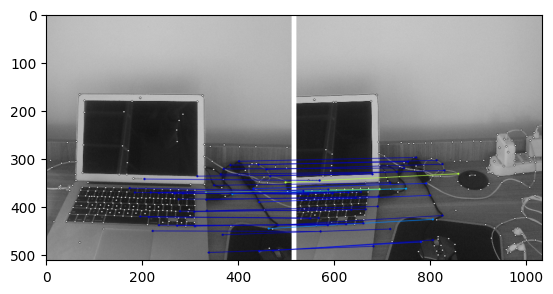

stitched 2 images


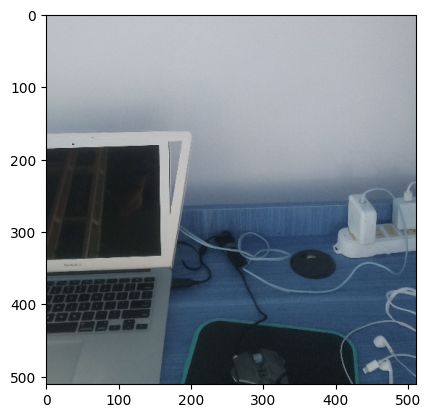

done


In [11]:
for idx, img in enumerate(imgs):
    if idx == 0:
        base_img = img
        continue
    base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    detected_datas = superglue.point_detect_all([base_gray, gray])
    base_pts, img_pts, conf, inliners = superglue.match_with_master_new(0, [base_gray, gray], [1,1], detected_datas)
    # 刚性形变
    res = stitch(base_img, img, base_pts, img_pts)
    # 去除黑色无效区域
    nonz = np.nonzero(res)
    base_img = res[np.min(nonz[0]):np.max(nonz[0]), np.min(nonz[1]):np.max(nonz[1])]
    print("stitched", idx + 1, "images")

plt.imshow(base_img)
plt.show()
print('done')

### GMM非刚性形变

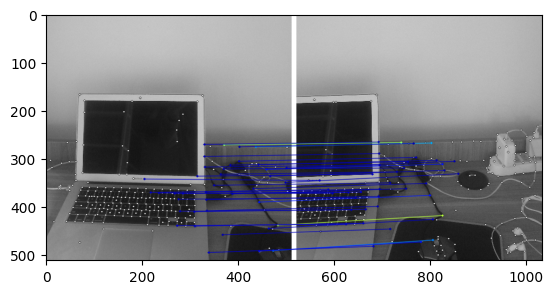

ic| X.shape: (50, 2)
ic| Y.shape: (50, 2)
ic| X_.shape: (6, 2)
ic| 'a :', a: 50, 'K=L :', L: 6
ic| iteration: 1
ic| Mp: 4.6252461118903545
ic| iteration: 2
ic| Mp: 25.23249109866147
ic| iteration: 3
ic| Mp: 47.83791089970062
ic| iteration: 4
ic| Mp: 49.93238598697591
ic| iteration: 5
ic| Mp: 49.95874137357771
ic| iteration: 6
ic| Mp: 49.96462218767701
ic| iteration: 7
ic| Mp: 49.9719253750279
ic| iteration: 8
ic| Mp: 49.978176538699444
ic| iteration: 9
ic| Mp: 49.98329232772122
ic| iteration: 10
ic| Mp: 49.987365888891475
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


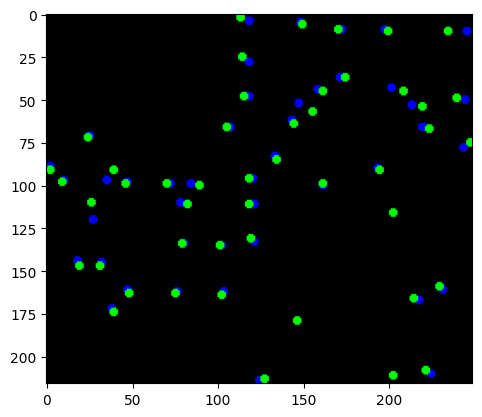

ic| GMM_time: 0.7460060119628906


gmm time 0.7460060119628906


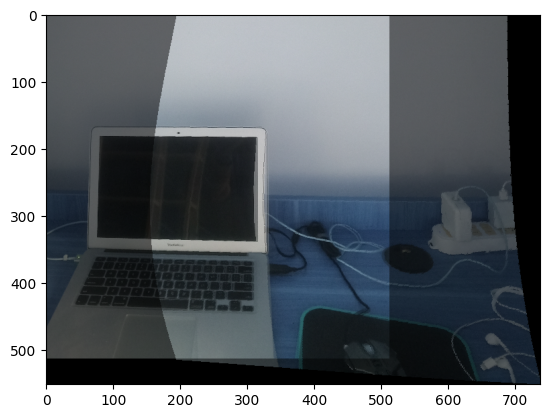

stitched 2 images


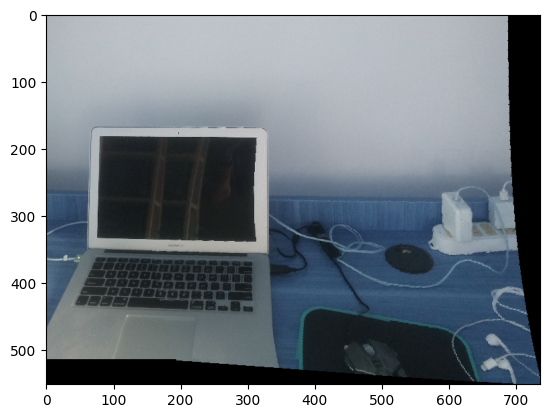

done


In [18]:
for idx, img in enumerate(imgs):
    if idx == 0:
        base_img = img
        continue
    base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    detected_datas = superglue.point_detect_all([base_gray, gray])
    base_pts, img_pts, conf, inliners = superglue.match_with_master_new(0, [base_gray, gray], [1,1], detected_datas)

    # 非刚性
    res = stitch_GMM(img, base_img, img_pts, base_pts, conf, inliners)
    # 去除黑色无效区域
    nonz = np.nonzero(res)
    base_img = res[np.min(nonz[0]):np.max(nonz[0]), np.min(nonz[1]):np.max(nonz[1])]
    print("stitched", idx + 1, "images")

plt.imshow(base_img)
plt.show()
print('done')